# Some tips with xarray and pandas

- We have massively different levels here
- Try to make some aims for technical skills you can learn!
- If you are beginning with python &rarr; learn the basics
- If you are good at basic python &rarr; learn new packages and tricks 
- If you know all the packages &rarr; improve your skills with producing your own software, organising your code etc. 
- If you don't know git and github &rarr; get better at this!
- **Learn from each other!**

<span style="color:red;font-weight:700;font-size:20px">
Please feel free to come with suggestions and extra input as we go! 
</span>



<span style="color:blue;font-weight:700;font-size:20px">
Questions:

- How many have used jupyter lab?     
- How many have used pandas? 
- How many have used xarray? 
</span>



## What are pandas and xarray?
- Pandas &rarr; like a spreadsheet 2D data with columns and rows
- xarray &rarr; like pandas, but in N dimensions
- **Use the functionality these packages gives you! Will help you avoid mistakes. Try to get as good as possible :)**


### Pandas
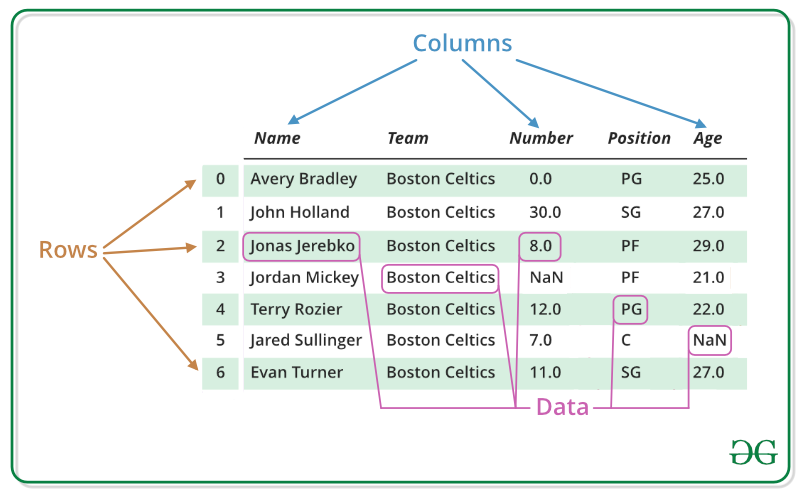
(Source: https://www.geeksforgeeks.org/python-pandas-dataframe/)

### Xarray
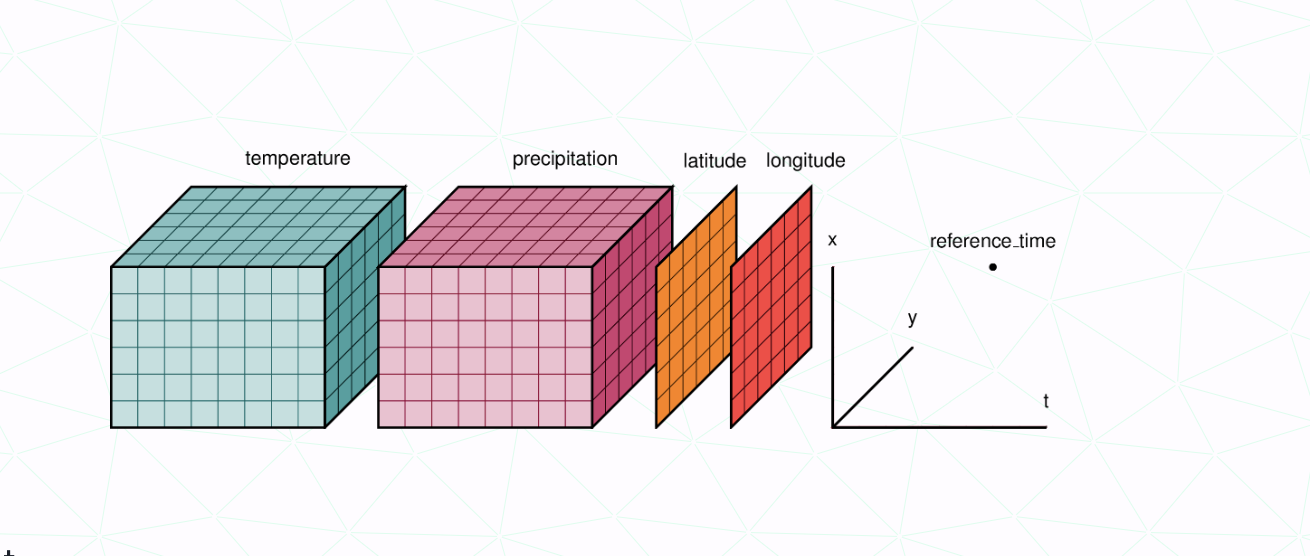
(Source: https://docs.xarray.dev/)

## 1. Read in CMIP6 data: We will skip this next part, but you can check it later to read data: 
#### Import python packages

In [1]:
import xarray as xr
xr.set_options(display_style='html')
import intake
import cftime
import matplotlib.pyplot as plt
import cartopy.crs as ccrs
import numpy as np
import pandas as pd
import datetime
import seaborn as sns

In [2]:
#cat_url = "https://storage.googleapis.com/cmip6/pangeo-cmip6.json"
#cat_url = "/mnt/craas1-ns9989k-geo4992/data/cmip6.json"
cat_url = '/mnt/craas1-ns9989k-geo4992/data/catalogs/cmip6.json'
col = intake.open_esm_datastore(cat_url)
col

,unique
variable_id,583
table_id,24
source_id,75
experiment_id,94
member_id,190
grid_label,11
time_range,9100
activity_id,18
institution_id,35
version,577



### Search corresponding data 

Please check [here](https://pangeo-data.github.io/escience-2022/pangeo101/data_discovery.html?highlight=cmip6) for info about CMIP and variables :) 

Particularly useful is maybe the variable search which you find here: https://clipc-services.ceda.ac.uk/dreq/mipVars.html 

In [3]:
cat = col.search(source_id = ['CESM2'], 
                 experiment_id=['historical'], 
                 table_id=['Amon','fx','AERmon'], 
                 variable_id=['tas','hurs', 'areacella','mmrso4' ], 
                 member_id=['r1i1p1f1'],
                )
cat.df


,variable_id,table_id,source_id,experiment_id,member_id,grid_label,time_range,activity_id,institution_id,version,path,dcpp_init_year
0,mmrso4,AERmon,CESM2,historical,r1i1p1f1,gn,185001-201412,CMIP,NCAR,v20190308,/mnt/craas1-ns9989k-ns9560k/ESGF/CMIP6/CMIP/NC...,NaN
1,hurs,Amon,CESM2,historical,r1i1p1f1,gn,185001-201412,CMIP,NCAR,v20190308,/mnt/craas1-ns9989k-ns9560k/ESGF/CMIP6/CMIP/NC...,NaN
2,tas,Amon,CESM2,historical,r1i1p1f1,gn,185001-201412,CMIP,NCAR,v20190308,/mnt/craas1-ns9989k-ns9560k/ESGF/CMIP6/CMIP/NC...,NaN
3,areacella,fx,CESM2,historical,r1i1p1f1,gn,NaN,CMIP,NCAR,v20190308,/mnt/craas1-ns9989k-ns9560k/ESGF/CMIP6/CMIP/NC...,NaN


In [4]:
cat.esmcat.aggregation_control.groupby_attrs = ['activity_id','experiment_id', 'source_id','table_id','grid_label']
cat.esmcat.aggregation_control.groupby_attrs

['activity_id', 'experiment_id', 'source_id', 'table_id', 'grid_label']

### Create dictionary from the list of datasets we found
- This step may take several minutes so be patient!

In [5]:
dset_dict = cat.to_dataset_dict(zarr_kwargs={'use_cftime':True})


--> The keys in the returned dictionary of datasets are constructed as follows:
	'activity_id.experiment_id.source_id.table_id.grid_label'


/opt/conda/envs/pangeo-notebook/lib/python3.11/site-packages/xarray/conventions.py:286: SerializationWarning: variable 'areacella' has multiple fill values {1e+20, 1e+20} defined, decoding all values to NaN.
  var = coder.decode(var, name=name)
/opt/conda/envs/pangeo-notebook/lib/python3.11/site-packages/xarray/conventions.py:286: SerializationWarning: variable 'hurs' has multiple fill values {1e+20, 1e+20} defined, decoding all values to NaN.
  var = coder.decode(var, name=name)
/opt/conda/envs/pangeo-notebook/lib/python3.11/site-packages/xarray/conventions.py:286: SerializationWarning: variable 'mmrso4' has multiple fill values {1e+20, 1e+20} defined, decoding all values to NaN.
  var = coder.decode(var, name=name)
/opt/conda/envs/pangeo-notebook/lib/python3.11/site-packages/xarray/conventions.py:286: SerializationWarning: variable 'tas' has multiple fill values {1e+20, 1e+20} defined, decoding all values to NaN.
  var = coder.decode(var, name=name)


In [6]:
list(dset_dict.keys())

['CMIP.historical.CESM2.fx.gn',
 'CMIP.historical.CESM2.AERmon.gn',
 'CMIP.historical.CESM2.Amon.gn']

<span style="color:black;font-weight:700;font-size:20px">
Since I have already checked that these datasets are on the same grid, we can merge them:
</span>




In [7]:
ds_list =[]
for k in dset_dict.keys():
    ds = dset_dict[k]
    for v in ['lon_bnds', 'lat_bnds', 'time_bnds']:
        if v in ds:
            ds= ds.drop(v)
    ds_list.append(ds)     
ds = xr.merge(ds_list,compat='override')

/tmp/ipykernel_14081/179335234.py:6: DeprecationWarning: dropping variables using `drop` is deprecated; use drop_vars.
  ds= ds.drop(v)


## 1.1 Reading in the data from file:

### Open dataset

- Use `xarray` python package to analyze netCDF dataset
- `open_dataset` allows to get all the metadata without loading data into memory. 
- with `xarray`, we only load into memory what is needed.

```python
path='filename.nc'
ds = xr.open_dataset(path)
```

##### Opening multiple files:

```python

list_of_files = [
    'file1.nc',
    'file2.nc'
]
xr.open_mfdataset(list_of_files, concat_dim='time',combine='by_coords')
```

## 2. Check how your dataset looks

<span style="color:red;font-weight:700;font-size:20px">
NetCDF + xarray = <3
</span>



NetCDF (Network Common Data Form) is a machine-independent data format (and software) that support the creation, access, and sharing of array-oriented scientific data. It was originally developed by UCAR (University Corporation for Atmospheric Research), and it's widely used in the atmospheric and oceanographic sciences, as well as in other fields such as Earth sciences, geophysics, and climatology.

**What is really great is that it keeps a lot of metadata (see below)**

Xarray is a Python library designed to work with multi-dimensional arrays and datasets, particularly those used in earth sciences, climate science, and atmospheric science. It builds upon and extends the functionality of **NumPy, Pandas, and NetCDF**, providing a high-level interface for working with **labeled, multi-dimensional data**.

#### Different types of information/data:
- Coordinates
- Data variables
- Global attributes
- Variable attributes
- Other? 

In [8]:
ds

<xarray.Dataset> Size: 15GB
Dimensions:    (member_id: 1, lat: 192, lon: 288, time: 1980, lev: 32, nbnd: 2)
Coordinates:
  * lat        (lat) float64 2kB -90.0 -89.06 -88.12 -87.17 ... 88.12 89.06 90.0
  * lon        (lon) float64 2kB 0.0 1.25 2.5 3.75 ... 355.0 356.2 357.5 358.8
  * member_id  (member_id) object 8B 'r1i1p1f1'
  * lev        (lev) float64 256B -3.643 -7.595 -14.36 ... -957.5 -976.3 -992.6
  * time       (time) object 16kB 1850-01-15 12:00:00 ... 2014-12-15 12:00:00
Dimensions without coordinates: nbnd
Data variables:
    areacella  (member_id, lat, lon) float32 221kB dask.array<chunksize=(1, 192, 288), meta=np.ndarray>
    mmrso4     (member_id, time, lev, lat, lon) float32 14GB dask.array<chunksize=(1, 1, 16, 96, 144), meta=np.ndarray>
    ps         (time, lat, lon) float32 438MB dask.array<chunksize=(1, 192, 288), meta=np.ndarray>
    p0         float32 4B ...
    a          (lev) float64 256B dask.array<chunksize=(32,), meta=np.ndarray>
    b          (lev) float64 256B dask.array<chunksize=(32,), meta=np.ndarray>
    b_bnds     (lev, nbnd) float64 512B dask.array<chunksize=(32, 2), meta=np.ndarray>
    lev_bnds   (lev, nbnd) float64 512B dask.array<chunksize=(32, 2), meta=np.ndarray>
    a_bnds     (lev, nbnd) float64 512B dask.array<chunksize=(32, 2), meta=np.ndarray>
    hurs       (member_id, time, lat, lon) float32 438MB dask.array<chunksize=(1, 1, 192, 288), meta=np.ndarray>
    tas        (member_id, time, lat, lon) float32 438MB dask.array<chunksize=(1, 1, 192, 288), meta=np.ndarray>
Attributes: (12/57)
    Conventions:                      CF-1.7 CMIP-6.2
    activity_id:                      CMIP
    case_id:                          15
    cesm_casename:                    b.e21.BHIST.f09_g17.CMIP6-historical.001
    contact:                          cesm_cmip6@ucar.edu
    creation_date:                    2019-01-16T21:43:39Z
    ...                               ...
    intake_esm_attrs:activity_id:     CMIP
    intake_esm_attrs:institution_id:  NCAR
    intake_esm_attrs:version:         v20190308
    intake_esm_attrs:path:            /mnt/craas1-ns9989k-ns9560k/ESGF/CMIP6/...
    intake_esm_attrs:_data_format_:   netcdf
    intake_esm_dataset_key:           CMIP.historical.CESM2.fx.gn

## 3. Sometimes we want to do some nice tweaks before we start: 

### Selecting data and super quick plotting:

xarray loads data only when it needs to (it's lazy, someone else can explain), and you might want to early on define the subset of data you want to look at so that you don't end up loading a lot of extra data. 


##### See [here](http://xarray.pydata.org/en/stable/user-guide/indexing.html) for nice overview

In order to reduce unecessary calculations and loading of data, think about which part of the data you want, and slice early on. 

### Slice in time: the sel method

In [9]:
dss = ds.sel(time = slice('1990-01-01','2010-01-01'))

In [10]:
dss

<xarray.Dataset> Size: 2GB
Dimensions:    (member_id: 1, lat: 192, lon: 288, time: 240, lev: 32, nbnd: 2)
Coordinates:
  * lat        (lat) float64 2kB -90.0 -89.06 -88.12 -87.17 ... 88.12 89.06 90.0
  * lon        (lon) float64 2kB 0.0 1.25 2.5 3.75 ... 355.0 356.2 357.5 358.8
  * member_id  (member_id) object 8B 'r1i1p1f1'
  * lev        (lev) float64 256B -3.643 -7.595 -14.36 ... -957.5 -976.3 -992.6
  * time       (time) object 2kB 1990-01-15 12:00:00 ... 2009-12-15 12:00:00
Dimensions without coordinates: nbnd
Data variables:
    areacella  (member_id, lat, lon) float32 221kB dask.array<chunksize=(1, 192, 288), meta=np.ndarray>
    mmrso4     (member_id, time, lev, lat, lon) float32 2GB dask.array<chunksize=(1, 1, 16, 96, 144), meta=np.ndarray>
    ps         (time, lat, lon) float32 53MB dask.array<chunksize=(1, 192, 288), meta=np.ndarray>
    p0         float32 4B ...
    a          (lev) float64 256B dask.array<chunksize=(32,), meta=np.ndarray>
    b          (lev) float64 256B dask.array<chunksize=(32,), meta=np.ndarray>
    b_bnds     (lev, nbnd) float64 512B dask.array<chunksize=(32, 2), meta=np.ndarray>
    lev_bnds   (lev, nbnd) float64 512B dask.array<chunksize=(32, 2), meta=np.ndarray>
    a_bnds     (lev, nbnd) float64 512B dask.array<chunksize=(32, 2), meta=np.ndarray>
    hurs       (member_id, time, lat, lon) float32 53MB dask.array<chunksize=(1, 1, 192, 288), meta=np.ndarray>
    tas        (member_id, time, lat, lon) float32 53MB dask.array<chunksize=(1, 1, 192, 288), meta=np.ndarray>
Attributes: (12/57)
    Conventions:                      CF-1.7 CMIP-6.2
    activity_id:                      CMIP
    case_id:                          15
    cesm_casename:                    b.e21.BHIST.f09_g17.CMIP6-historical.001
    contact:                          cesm_cmip6@ucar.edu
    creation_date:                    2019-01-16T21:43:39Z
    ...                               ...
    intake_esm_attrs:activity_id:     CMIP
    intake_esm_attrs:institution_id:  NCAR
    intake_esm_attrs:version:         v20190308
    intake_esm_attrs:path:            /mnt/craas1-ns9989k-ns9560k/ESGF/CMIP6/...
    intake_esm_attrs:_data_format_:   netcdf
    intake_esm_dataset_key:           CMIP.historical.CESM2.fx.gn


<span style="color:red;font-weight:700;font-size:20px">
NB: Always check that the function you are using is doing what you expect!
</span>


You might even select only the arctic e.g.: 

In [11]:
dss_arctic = dss.sel(lat = slice(60,None))
dss_arctic

<xarray.Dataset> Size: 310MB
Dimensions:    (member_id: 1, lat: 32, lon: 288, time: 240, lev: 32, nbnd: 2)
Coordinates:
  * lat        (lat) float64 256B 60.79 61.73 62.67 63.61 ... 88.12 89.06 90.0
  * lon        (lon) float64 2kB 0.0 1.25 2.5 3.75 ... 355.0 356.2 357.5 358.8
  * member_id  (member_id) object 8B 'r1i1p1f1'
  * lev        (lev) float64 256B -3.643 -7.595 -14.36 ... -957.5 -976.3 -992.6
  * time       (time) object 2kB 1990-01-15 12:00:00 ... 2009-12-15 12:00:00
Dimensions without coordinates: nbnd
Data variables:
    areacella  (member_id, lat, lon) float32 37kB dask.array<chunksize=(1, 32, 288), meta=np.ndarray>
    mmrso4     (member_id, time, lev, lat, lon) float32 283MB dask.array<chunksize=(1, 1, 16, 32, 144), meta=np.ndarray>
    ps         (time, lat, lon) float32 9MB dask.array<chunksize=(1, 32, 288), meta=np.ndarray>
    p0         float32 4B ...
    a          (lev) float64 256B dask.array<chunksize=(32,), meta=np.ndarray>
    b          (lev) float64 256B dask.array<chunksize=(32,), meta=np.ndarray>
    b_bnds     (lev, nbnd) float64 512B dask.array<chunksize=(32, 2), meta=np.ndarray>
    lev_bnds   (lev, nbnd) float64 512B dask.array<chunksize=(32, 2), meta=np.ndarray>
    a_bnds     (lev, nbnd) float64 512B dask.array<chunksize=(32, 2), meta=np.ndarray>
    hurs       (member_id, time, lat, lon) float32 9MB dask.array<chunksize=(1, 1, 32, 288), meta=np.ndarray>
    tas        (member_id, time, lat, lon) float32 9MB dask.array<chunksize=(1, 1, 32, 288), meta=np.ndarray>
Attributes: (12/57)
    Conventions:                      CF-1.7 CMIP-6.2
    activity_id:                      CMIP
    case_id:                          15
    cesm_casename:                    b.e21.BHIST.f09_g17.CMIP6-historical.001
    contact:                          cesm_cmip6@ucar.edu
    creation_date:                    2019-01-16T21:43:39Z
    ...                               ...
    intake_esm_attrs:activity_id:     CMIP
    intake_esm_attrs:institution_id:  NCAR
    intake_esm_attrs:version:         v20190308
    intake_esm_attrs:path:            /mnt/craas1-ns9989k-ns9560k/ESGF/CMIP6/...
    intake_esm_attrs:_data_format_:   netcdf
    intake_esm_dataset_key:           CMIP.historical.CESM2.fx.gn

#### isel, sel: index selecting 

Select the surface (which in this case is the last index :) 

In [12]:
dss

<xarray.Dataset> Size: 2GB
Dimensions:    (member_id: 1, lat: 192, lon: 288, time: 240, lev: 32, nbnd: 2)
Coordinates:
  * lat        (lat) float64 2kB -90.0 -89.06 -88.12 -87.17 ... 88.12 89.06 90.0
  * lon        (lon) float64 2kB 0.0 1.25 2.5 3.75 ... 355.0 356.2 357.5 358.8
  * member_id  (member_id) object 8B 'r1i1p1f1'
  * lev        (lev) float64 256B -3.643 -7.595 -14.36 ... -957.5 -976.3 -992.6
  * time       (time) object 2kB 1990-01-15 12:00:00 ... 2009-12-15 12:00:00
Dimensions without coordinates: nbnd
Data variables:
    areacella  (member_id, lat, lon) float32 221kB dask.array<chunksize=(1, 192, 288), meta=np.ndarray>
    mmrso4     (member_id, time, lev, lat, lon) float32 2GB dask.array<chunksize=(1, 1, 16, 96, 144), meta=np.ndarray>
    ps         (time, lat, lon) float32 53MB dask.array<chunksize=(1, 192, 288), meta=np.ndarray>
    p0         float32 4B ...
    a          (lev) float64 256B dask.array<chunksize=(32,), meta=np.ndarray>
    b          (lev) float64 256B dask.array<chunksize=(32,), meta=np.ndarray>
    b_bnds     (lev, nbnd) float64 512B dask.array<chunksize=(32, 2), meta=np.ndarray>
    lev_bnds   (lev, nbnd) float64 512B dask.array<chunksize=(32, 2), meta=np.ndarray>
    a_bnds     (lev, nbnd) float64 512B dask.array<chunksize=(32, 2), meta=np.ndarray>
    hurs       (member_id, time, lat, lon) float32 53MB dask.array<chunksize=(1, 1, 192, 288), meta=np.ndarray>
    tas        (member_id, time, lat, lon) float32 53MB dask.array<chunksize=(1, 1, 192, 288), meta=np.ndarray>
Attributes: (12/57)
    Conventions:                      CF-1.7 CMIP-6.2
    activity_id:                      CMIP
    case_id:                          15
    cesm_casename:                    b.e21.BHIST.f09_g17.CMIP6-historical.001
    contact:                          cesm_cmip6@ucar.edu
    creation_date:                    2019-01-16T21:43:39Z
    ...                               ...
    intake_esm_attrs:activity_id:     CMIP
    intake_esm_attrs:institution_id:  NCAR
    intake_esm_attrs:version:         v20190308
    intake_esm_attrs:path:            /mnt/craas1-ns9989k-ns9560k/ESGF/CMIP6/...
    intake_esm_attrs:_data_format_:   netcdf
    intake_esm_dataset_key:           CMIP.historical.CESM2.fx.gn

In [13]:
dss_s = dss.isel(lev=-1)

In [14]:
dss_s

<xarray.Dataset> Size: 213MB
Dimensions:    (member_id: 1, lat: 192, lon: 288, time: 240, nbnd: 2)
Coordinates:
  * lat        (lat) float64 2kB -90.0 -89.06 -88.12 -87.17 ... 88.12 89.06 90.0
  * lon        (lon) float64 2kB 0.0 1.25 2.5 3.75 ... 355.0 356.2 357.5 358.8
  * member_id  (member_id) object 8B 'r1i1p1f1'
    lev        float64 8B -992.6
  * time       (time) object 2kB 1990-01-15 12:00:00 ... 2009-12-15 12:00:00
Dimensions without coordinates: nbnd
Data variables:
    areacella  (member_id, lat, lon) float32 221kB dask.array<chunksize=(1, 192, 288), meta=np.ndarray>
    mmrso4     (member_id, time, lat, lon) float32 53MB dask.array<chunksize=(1, 1, 96, 144), meta=np.ndarray>
    ps         (time, lat, lon) float32 53MB dask.array<chunksize=(1, 192, 288), meta=np.ndarray>
    p0         float32 4B ...
    a          float64 8B dask.array<chunksize=(), meta=np.ndarray>
    b          float64 8B dask.array<chunksize=(), meta=np.ndarray>
    b_bnds     (nbnd) float64 16B dask.array<chunksize=(2,), meta=np.ndarray>
    lev_bnds   (nbnd) float64 16B dask.array<chunksize=(2,), meta=np.ndarray>
    a_bnds     (nbnd) float64 16B dask.array<chunksize=(2,), meta=np.ndarray>
    hurs       (member_id, time, lat, lon) float32 53MB dask.array<chunksize=(1, 1, 192, 288), meta=np.ndarray>
    tas        (member_id, time, lat, lon) float32 53MB dask.array<chunksize=(1, 1, 192, 288), meta=np.ndarray>
Attributes: (12/57)
    Conventions:                      CF-1.7 CMIP-6.2
    activity_id:                      CMIP
    case_id:                          15
    cesm_casename:                    b.e21.BHIST.f09_g17.CMIP6-historical.001
    contact:                          cesm_cmip6@ucar.edu
    creation_date:                    2019-01-16T21:43:39Z
    ...                               ...
    intake_esm_attrs:activity_id:     CMIP
    intake_esm_attrs:institution_id:  NCAR
    intake_esm_attrs:version:         v20190308
    intake_esm_attrs:path:            /mnt/craas1-ns9989k-ns9560k/ESGF/CMIP6/...
    intake_esm_attrs:_data_format_:   netcdf
    intake_esm_dataset_key:           CMIP.historical.CESM2.fx.gn

## 3.2 Calculates variables and assign attributes! 
Nice for plotting and to keep track of what is in your dataset (especially 'units' and 'standard_name'/'long_name' will be looked for by xarray.

In [15]:
dss['T_C'] = dss['tas']-273.15

In [16]:
dss['T_C'] = dss['T_C'].assign_attrs({'units': '$^\circ$C'})

In [17]:
dss['T_C']

<xarray.DataArray 'T_C' (member_id: 1, time: 240, lat: 192, lon: 288)> Size: 53MB
dask.array<sub, shape=(1, 240, 192, 288), dtype=float32, chunksize=(1, 1, 192, 288), chunktype=numpy.ndarray>
Coordinates:
  * lat        (lat) float64 2kB -90.0 -89.06 -88.12 -87.17 ... 88.12 89.06 90.0
  * lon        (lon) float64 2kB 0.0 1.25 2.5 3.75 ... 355.0 356.2 357.5 358.8
  * member_id  (member_id) object 8B 'r1i1p1f1'
  * time       (time) object 2kB 1990-01-15 12:00:00 ... 2009-12-15 12:00:00
Attributes:
    units:    $^\circ$C

<span style="color:green;font-weight:700;font-size:20px">
May always be small things you need to adjust: 
</span>



In [18]:
dss['time']

<xarray.DataArray 'time' (time: 240)> Size: 2kB
array([cftime.DatetimeNoLeap(1990, 1, 15, 12, 0, 0, 0, has_year_zero=True),
       cftime.DatetimeNoLeap(1990, 2, 14, 0, 0, 0, 0, has_year_zero=True),
       cftime.DatetimeNoLeap(1990, 3, 15, 12, 0, 0, 0, has_year_zero=True),
       ...,
       cftime.DatetimeNoLeap(2009, 10, 15, 12, 0, 0, 0, has_year_zero=True),
       cftime.DatetimeNoLeap(2009, 11, 15, 0, 0, 0, 0, has_year_zero=True),
       cftime.DatetimeNoLeap(2009, 12, 15, 12, 0, 0, 0, has_year_zero=True)],
      dtype=object)
Coordinates:
  * time     (time) object 2kB 1990-01-15 12:00:00 ... 2009-12-15 12:00:00
Attributes:
    axis:           T
    bounds:         time_bnds
    standard_name:  time
    title:          time
    type:           double

This calendar is in cftime and noLeap. Sometimes this causes issues when plotting timeseries, so just for fun we will convert to a standard datetime64 index calendar because it's anyway monthly.

In [19]:
dss['time'] = dss['time'].to_dataframe().index.to_datetimeindex()

/tmp/ipykernel_14081/4195133999.py:1: RuntimeWarning: Converting a CFTimeIndex with dates from a non-standard calendar, 'noleap', to a pandas.DatetimeIndex, which uses dates from the standard calendar.  This may lead to subtle errors in operations that depend on the length of time between dates.
  dss['time'] = dss['time'].to_dataframe().index.to_datetimeindex()


In [20]:
dss['time']

<xarray.DataArray 'time' (time: 240)> Size: 2kB
array(['1990-01-15T12:00:00.000000000', '1990-02-14T00:00:00.000000000',
       '1990-03-15T12:00:00.000000000', ..., '2009-10-15T12:00:00.000000000',
       '2009-11-15T00:00:00.000000000', '2009-12-15T12:00:00.000000000'],
      dtype='datetime64[ns]')
Coordinates:
  * time     (time) datetime64[ns] 2kB 1990-01-15T12:00:00 ... 2009-12-15T12:...


<span style="color:green;font-weight:700;font-size:20px">
We get a warning, but it's ok as long as we know what we are doing. 
</span>




### 3.3 Convert longitude: 
this data comes in 0--360 degrees, but often -180 to 180 is more convenient. So we can convert:

**NOTE:** Maybe you want to put this in a module? Or a package.. 

In [21]:
dss

<xarray.Dataset> Size: 2GB
Dimensions:    (member_id: 1, lat: 192, lon: 288, time: 240, lev: 32, nbnd: 2)
Coordinates:
  * lat        (lat) float64 2kB -90.0 -89.06 -88.12 -87.17 ... 88.12 89.06 90.0
  * lon        (lon) float64 2kB 0.0 1.25 2.5 3.75 ... 355.0 356.2 357.5 358.8
  * member_id  (member_id) object 8B 'r1i1p1f1'
  * lev        (lev) float64 256B -3.643 -7.595 -14.36 ... -957.5 -976.3 -992.6
  * time       (time) datetime64[ns] 2kB 1990-01-15T12:00:00 ... 2009-12-15T1...
Dimensions without coordinates: nbnd
Data variables:
    areacella  (member_id, lat, lon) float32 221kB dask.array<chunksize=(1, 192, 288), meta=np.ndarray>
    mmrso4     (member_id, time, lev, lat, lon) float32 2GB dask.array<chunksize=(1, 1, 16, 96, 144), meta=np.ndarray>
    ps         (time, lat, lon) float32 53MB dask.array<chunksize=(1, 192, 288), meta=np.ndarray>
    p0         float32 4B ...
    a          (lev) float64 256B dask.array<chunksize=(32,), meta=np.ndarray>
    b          (lev) float64 256B dask.array<chunksize=(32,), meta=np.ndarray>
    b_bnds     (lev, nbnd) float64 512B dask.array<chunksize=(32, 2), meta=np.ndarray>
    lev_bnds   (lev, nbnd) float64 512B dask.array<chunksize=(32, 2), meta=np.ndarray>
    a_bnds     (lev, nbnd) float64 512B dask.array<chunksize=(32, 2), meta=np.ndarray>
    hurs       (member_id, time, lat, lon) float32 53MB dask.array<chunksize=(1, 1, 192, 288), meta=np.ndarray>
    tas        (member_id, time, lat, lon) float32 53MB dask.array<chunksize=(1, 1, 192, 288), meta=np.ndarray>
    T_C        (member_id, time, lat, lon) float32 53MB dask.array<chunksize=(1, 1, 192, 288), meta=np.ndarray>
Attributes: (12/57)
    Conventions:                      CF-1.7 CMIP-6.2
    activity_id:                      CMIP
    case_id:                          15
    cesm_casename:                    b.e21.BHIST.f09_g17.CMIP6-historical.001
    contact:                          cesm_cmip6@ucar.edu
    creation_date:                    2019-01-16T21:43:39Z
    ...                               ...
    intake_esm_attrs:activity_id:     CMIP
    intake_esm_attrs:institution_id:  NCAR
    intake_esm_attrs:version:         v20190308
    intake_esm_attrs:path:            /mnt/craas1-ns9989k-ns9560k/ESGF/CMIP6/...
    intake_esm_attrs:_data_format_:   netcdf
    intake_esm_dataset_key:           CMIP.historical.CESM2.fx.gn

In [22]:
def convert_lon_to_180(ds):
    ds['lon'] =(ds['lon']+ 180) % 360 - 180
    ds = ds.sortby('lon')
    return ds

def convert_lon_to_360(ds):
    ds['lon'] =ds['lon']% 360
    ds = ds.sortby('lon')
    return lon % 360

(migth want to move this to a module!) 

In [23]:
dss = convert_lon_to_180(dss)

In [24]:
dss['lon'].attrs['units'] = '$^\circ$ East'

Notice how the labels use both the attribute "standard_name" and "units" from the dataset. 

## 4. The easiest interpolation: select with 'nearest' neighboor

Example: let's select zeppelin station: 
78.906661, 11.889203

In [25]:
lat_zep = 78.906661
lon_zep = 11.889203

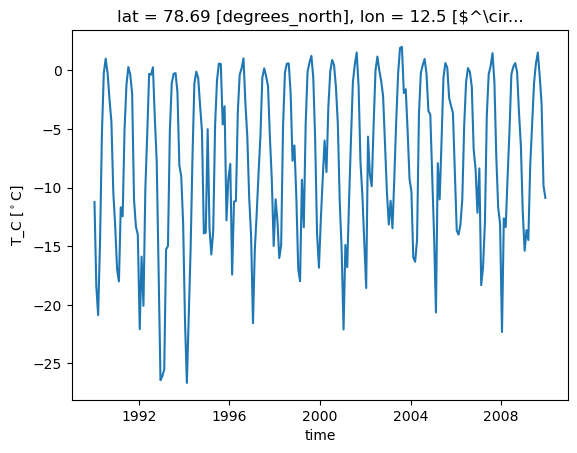

In [26]:
dss['T_C'].sel(lon=lon_zep, lat=lat_zep, method='nearest').plot()

### Super quick averaging etc

In [27]:
da_so4 = dss['mmrso4']
da_so4

<xarray.DataArray 'mmrso4' (member_id: 1, time: 240, lev: 32, lat: 192, lon: 288)> Size: 2GB
dask.array<getitem, shape=(1, 240, 32, 192, 288), dtype=float32, chunksize=(1, 1, 16, 96, 144), chunktype=numpy.ndarray>
Coordinates:
  * lat        (lat) float64 2kB -90.0 -89.06 -88.12 -87.17 ... 88.12 89.06 90.0
  * lon        (lon) float64 2kB -180.0 -178.8 -177.5 ... 176.2 177.5 178.8
  * member_id  (member_id) object 8B 'r1i1p1f1'
  * lev        (lev) float64 256B -3.643 -7.595 -14.36 ... -957.5 -976.3 -992.6
  * time       (time) datetime64[ns] 2kB 1990-01-15T12:00:00 ... 2009-12-15T1...
Attributes: (12/19)
    cell_measures:  area: areacella
    cell_methods:   area: time: mean
    comment:        Dry mass of sulfate (SO4) in aerosol particles as a fract...
    description:    Dry mass of sulfate (SO4) in aerosol particles as a fract...
    frequency:      mon
    id:             mmrso4
    ...             ...
    time_label:     time-mean
    time_title:     Temporal mean
    title:          Aerosol Sulfate Mass Mixing Ratio
    type:           real
    units:          kg kg-1
    variable_id:    mmrso4

Mean: 
  

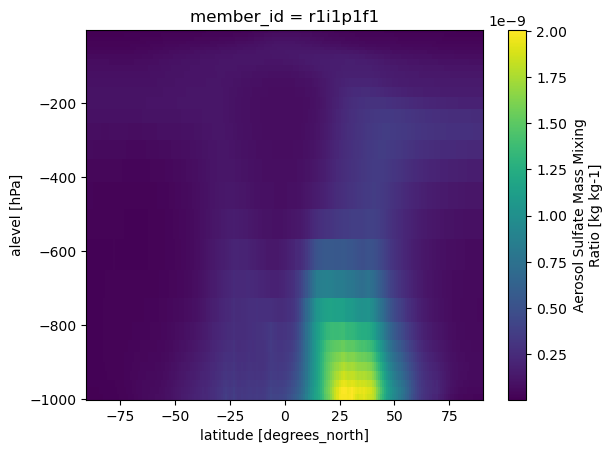

In [28]:
da_so4.mean(['time','lon'], keep_attrs=True).plot()#ylim=[1000,100], yscale='log')

In [29]:
da_so4['lev'] = np.abs(da_so4['lev'].values)

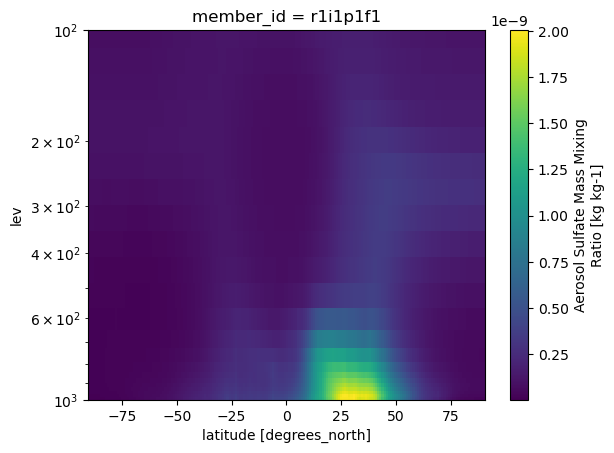

In [30]:
da_so4.mean(['time','lon'], keep_attrs=True).plot(
    ylim=[1000,100], 
    yscale='log'
)

Standard deviation

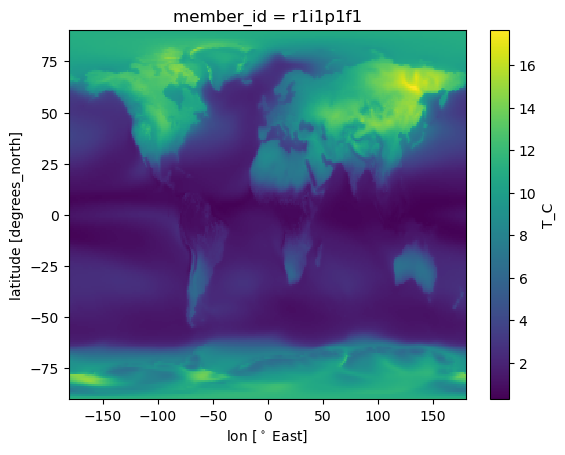

In [31]:
dss['T_C'].std(['time']).plot()

Temperature change much stronger over land than ocean and higher at high latitudes...

## 5. Mask data and groupby: pick out seasons

In [32]:
month = ds['time.month']

In [33]:
month

<xarray.DataArray 'month' (time: 1980)> Size: 16kB
array([ 1,  2,  3, ..., 10, 11, 12])
Coordinates:
  * time     (time) object 16kB 1850-01-15 12:00:00 ... 2014-12-15 12:00:00

In [34]:
dss_JA = dss.where(month.isin([7,8])).mean('time')

In [35]:
dss_JA

<xarray.Dataset> Size: 8MB
Dimensions:    (member_id: 1, lat: 192, lon: 288, lev: 32, nbnd: 2)
Coordinates:
  * lat        (lat) float64 2kB -90.0 -89.06 -88.12 -87.17 ... 88.12 89.06 90.0
  * lon        (lon) float64 2kB -180.0 -178.8 -177.5 ... 176.2 177.5 178.8
  * member_id  (member_id) object 8B 'r1i1p1f1'
  * lev        (lev) float64 256B -3.643 -7.595 -14.36 ... -957.5 -976.3 -992.6
Dimensions without coordinates: nbnd
Data variables:
    areacella  (member_id, lat, lon) float32 221kB dask.array<chunksize=(1, 192, 288), meta=np.ndarray>
    mmrso4     (member_id, lev, lat, lon) float32 7MB dask.array<chunksize=(1, 16, 96, 144), meta=np.ndarray>
    ps         (lat, lon) float32 221kB dask.array<chunksize=(192, 288), meta=np.ndarray>
    p0         float32 4B nan
    a          (lev) float64 256B dask.array<chunksize=(32,), meta=np.ndarray>
    b          (lev) float64 256B dask.array<chunksize=(32,), meta=np.ndarray>
    b_bnds     (lev, nbnd) float64 512B dask.array<chunksize=(32, 2), meta=np.ndarray>
    lev_bnds   (lev, nbnd) float64 512B dask.array<chunksize=(32, 2), meta=np.ndarray>
    a_bnds     (lev, nbnd) float64 512B dask.array<chunksize=(32, 2), meta=np.ndarray>
    hurs       (member_id, lat, lon) float32 221kB dask.array<chunksize=(1, 192, 288), meta=np.ndarray>
    tas        (member_id, lat, lon) float32 221kB dask.array<chunksize=(1, 192, 288), meta=np.ndarray>
    T_C        (member_id, lat, lon) float32 221kB dask.array<chunksize=(1, 192, 288), meta=np.ndarray>

In [36]:
dss_season = dss.groupby('time.season').mean(keep_attrs=True)

In [37]:
dss_season

<xarray.Dataset> Size: 33MB
Dimensions:    (season: 4, member_id: 1, lev: 32, lat: 192, lon: 288, nbnd: 2)
Coordinates:
  * lat        (lat) float64 2kB -90.0 -89.06 -88.12 -87.17 ... 88.12 89.06 90.0
  * lon        (lon) float64 2kB -180.0 -178.8 -177.5 ... 176.2 177.5 178.8
  * member_id  (member_id) object 8B 'r1i1p1f1'
  * lev        (lev) float64 256B -3.643 -7.595 -14.36 ... -957.5 -976.3 -992.6
  * season     (season) object 32B 'DJF' 'JJA' 'MAM' 'SON'
Dimensions without coordinates: nbnd
Data variables:
    mmrso4     (season, member_id, lev, lat, lon) float32 28MB dask.array<chunksize=(1, 1, 16, 96, 144), meta=np.ndarray>
    ps         (season, lat, lon) float32 885kB dask.array<chunksize=(1, 192, 288), meta=np.ndarray>
    hurs       (season, member_id, lat, lon) float32 885kB dask.array<chunksize=(1, 1, 192, 288), meta=np.ndarray>
    tas        (season, member_id, lat, lon) float32 885kB dask.array<chunksize=(1, 1, 192, 288), meta=np.ndarray>
    T_C        (season, member_id, lat, lon) float32 885kB dask.array<chunksize=(1, 1, 192, 288), meta=np.ndarray>
    areacella  (season, member_id, lat, lon) float32 885kB dask.array<chunksize=(4, 1, 192, 288), meta=np.ndarray>
    p0         (season) float32 16B 1e+05 1e+05 1e+05 1e+05
    a          (season, lev) float64 1kB dask.array<chunksize=(4, 32), meta=np.ndarray>
    b          (season, lev) float64 1kB dask.array<chunksize=(4, 32), meta=np.ndarray>
    b_bnds     (season, lev, nbnd) float64 2kB dask.array<chunksize=(4, 32, 2), meta=np.ndarray>
    lev_bnds   (season, lev, nbnd) float64 2kB dask.array<chunksize=(4, 32, 2), meta=np.ndarray>
    a_bnds     (season, lev, nbnd) float64 2kB dask.array<chunksize=(4, 32, 2), meta=np.ndarray>
Attributes: (12/57)
    Conventions:                      CF-1.7 CMIP-6.2
    activity_id:                      CMIP
    case_id:                          15
    cesm_casename:                    b.e21.BHIST.f09_g17.CMIP6-historical.001
    contact:                          cesm_cmip6@ucar.edu
    creation_date:                    2019-01-16T21:43:39Z
    ...                               ...
    intake_esm_attrs:activity_id:     CMIP
    intake_esm_attrs:institution_id:  NCAR
    intake_esm_attrs:version:         v20190308
    intake_esm_attrs:path:            /mnt/craas1-ns9989k-ns9560k/ESGF/CMIP6/...
    intake_esm_attrs:_data_format_:   netcdf
    intake_esm_dataset_key:           CMIP.historical.CESM2.fx.gn

In [38]:
da_TC = dss_season['T_C']

CPU times: user 21min 5s, sys: 3min 15s, total: 24min 20s
Wall time: 3min 13s


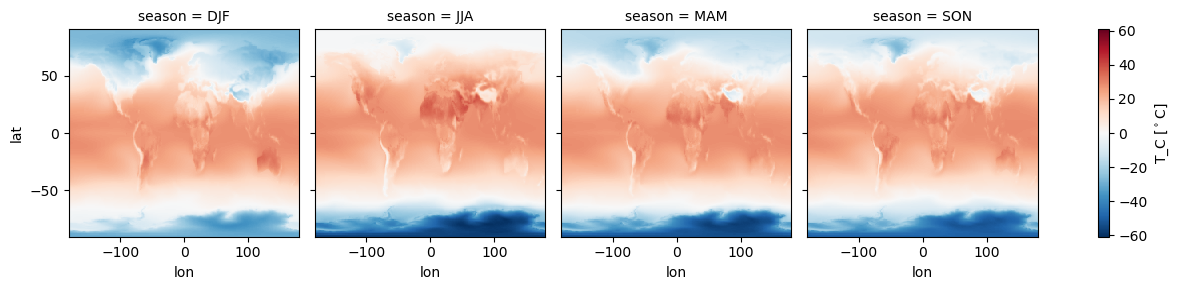

In [39]:
%%time
da_TC.plot(col='season')

### Tip: Might want to load or compute. 

In [40]:
from dask.diagnostics import ProgressBar

In [41]:
%%time
with ProgressBar():
    da_TC.load()

[########################################] | 100% Completed | 51.84 s
CPU times: user 10min 8s, sys: 3min 37s, total: 13min 46s
Wall time: 51.9 s


## 6. Controle the plot visuals:

CPU times: user 644 ms, sys: 55.8 ms, total: 700 ms
Wall time: 702 ms


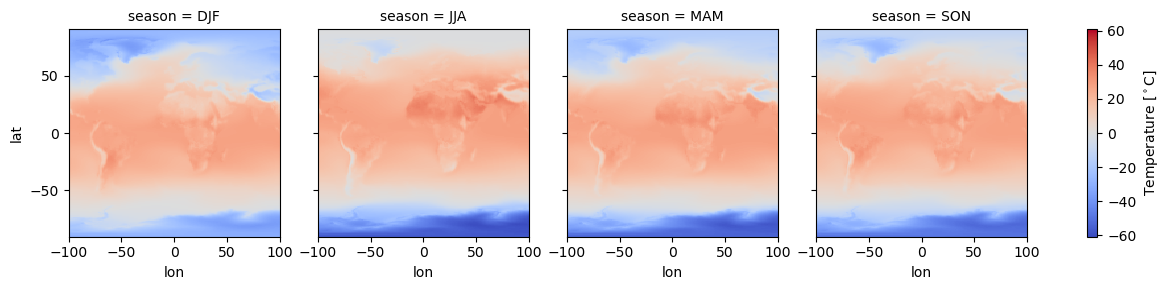

In [42]:
%%time
da_TC.plot(
    col = 'season',
    cmap = 'coolwarm',
    xlim = [-100,100],
    cbar_kwargs = {'label':'Temperature [$^\circ$C]'}
    )

In [43]:
da_TC = da_TC.assign_attrs({'long_name': 'Temperature near surface'})

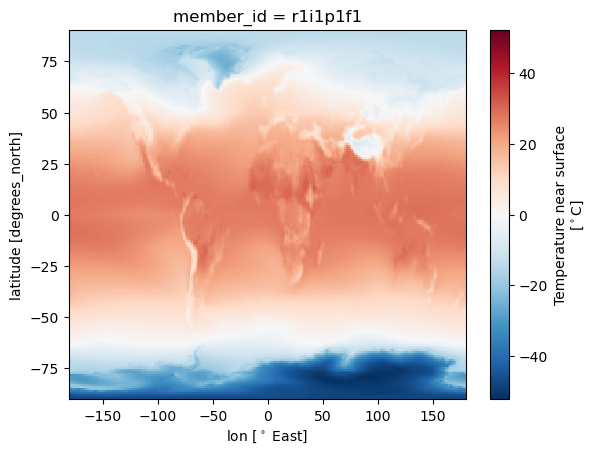

In [44]:
da_TC.mean('season', keep_attrs=True).plot()

## 7. Plotting with cartopy

See more here: 
- [Plotting with xarray](https://docs.xarray.dev/en/stable/user-guide/plotting.html)
- [Plotting with cartopy and xarray](https://tutorial.xarray.dev/fundamentals/04.3_geographic_plotting.html)

In [45]:
import cartopy as cy
import cartopy.crs as ccrs

In [46]:
da_plt = dss['mmrso4'].isel(lev=-1).mean('time', keep_attrs=True).squeeze()#('member_id')

In [47]:
da_plt

<xarray.DataArray 'mmrso4' (lat: 192, lon: 288)> Size: 221kB
dask.array<getitem, shape=(192, 288), dtype=float32, chunksize=(96, 144), chunktype=numpy.ndarray>
Coordinates:
  * lat        (lat) float64 2kB -90.0 -89.06 -88.12 -87.17 ... 88.12 89.06 90.0
  * lon        (lon) float64 2kB -180.0 -178.8 -177.5 ... 176.2 177.5 178.8
    member_id  <U8 32B 'r1i1p1f1'
    lev        float64 8B -992.6
Attributes: (12/19)
    cell_measures:  area: areacella
    cell_methods:   area: time: mean
    comment:        Dry mass of sulfate (SO4) in aerosol particles as a fract...
    description:    Dry mass of sulfate (SO4) in aerosol particles as a fract...
    frequency:      mon
    id:             mmrso4
    ...             ...
    time_label:     time-mean
    time_title:     Temporal mean
    title:          Aerosol Sulfate Mass Mixing Ratio
    type:           real
    units:          kg kg-1
    variable_id:    mmrso4

In [48]:
from matplotlib.colors import LogNorm

In [49]:
with ProgressBar():
    da_plt.load()

[########################################] | 100% Completed | 3.53 sms


In [50]:
da_plt

<xarray.DataArray 'mmrso4' (lat: 192, lon: 288)> Size: 221kB
array([[7.0655864e-12, 7.0656254e-12, 7.0656757e-12, ..., 7.0654580e-12,
        7.0654359e-12, 7.0655357e-12],
       [7.4523243e-12, 7.4701799e-12, 7.4873961e-12, ..., 7.3945355e-12,
        7.4097612e-12, 7.4321209e-12],
       [8.0703352e-12, 8.0987569e-12, 8.1331625e-12, ..., 7.9838211e-12,
        8.0185901e-12, 8.0491083e-12],
       ...,
       [3.2195205e-11, 3.2224824e-11, 3.2185157e-11, ..., 3.2204971e-11,
        3.2198522e-11, 3.2200648e-11],
       [3.1399085e-11, 3.1360515e-11, 3.1390588e-11, ..., 3.1466201e-11,
        3.1436742e-11, 3.1405465e-11],
       [3.0563073e-11, 3.0563111e-11, 3.0562844e-11, ..., 3.0563923e-11,
        3.0565092e-11, 3.0564863e-11]], dtype=float32)
Coordinates:
  * lat        (lat) float64 2kB -90.0 -89.06 -88.12 -87.17 ... 88.12 89.06 90.0
  * lon        (lon) float64 2kB -180.0 -178.8 -177.5 ... 176.2 177.5 178.8
    member_id  <U8 32B 'r1i1p1f1'
    lev        float64 8B -992.6
Attributes: (12/19)
    cell_measures:  area: areacella
    cell_methods:   area: time: mean
    comment:        Dry mass of sulfate (SO4) in aerosol particles as a fract...
    description:    Dry mass of sulfate (SO4) in aerosol particles as a fract...
    frequency:      mon
    id:             mmrso4
    ...             ...
    time_label:     time-mean
    time_title:     Temporal mean
    title:          Aerosol Sulfate Mass Mixing Ratio
    type:           real
    units:          kg kg-1
    variable_id:    mmrso4

## My headline 
my comments


# comment number two



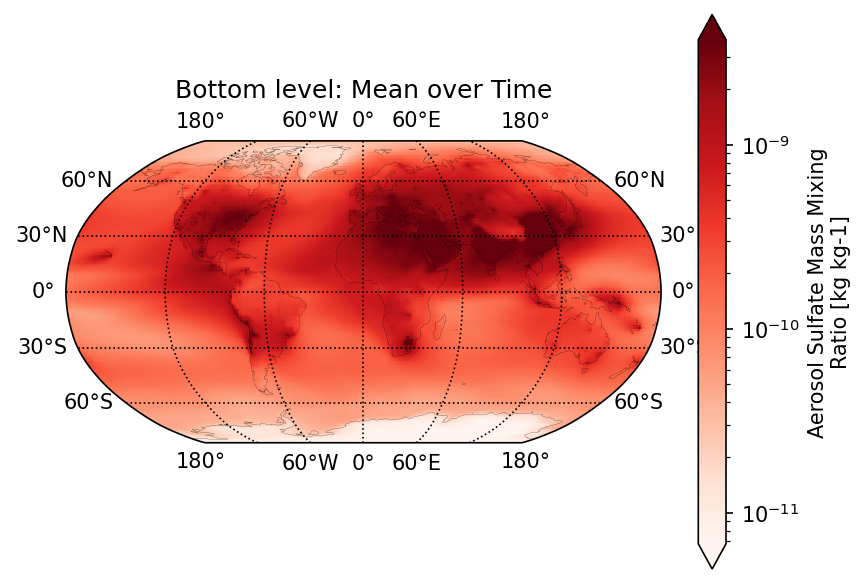

In [51]:
f, ax = plt.subplots(1, 1, dpi=150, 
                    subplot_kw={'projection':ccrs.Robinson()}
                   )

da_plt.plot.pcolormesh(
    cmap = 'Reds',
    ax=ax,
    transform = ccrs.PlateCarree(), 
    robust=True,
    norm = LogNorm(), # to add log scale colorbar
    #cbar_kwargs={
    #    #'label':'Wind Speed [m/s]', 
    #    'orientation':'horizontal',
    #    'shrink':.8
    #},
    #levels = 6
)
ax.set_title('Bottom level: Mean over Time')


ax.coastlines(linewidth=.1)
gl = ax.gridlines(draw_labels=True,#{'bottom':True, 'left':True},
                  #xlocs=[-180,-140,0,140, 180],
                  #ylocs=[-90,-45,0,45,90],
                  #x_inline=False,
                  #y_inline=False,
                  color='k',
                  linestyle='dotted'
                 )

## 8. Global average: weighted means!

In [52]:
dss['T_C'].mean().compute()

<xarray.DataArray 'T_C' ()> Size: 4B
array(5.4478564, dtype=float32)

**Why is this wrong?**

In [53]:
dss['T_C'].weighted(dss['areacella']).mean().compute()

<xarray.DataArray 'T_C' ()> Size: 4B
array(14.715008, dtype=float32)

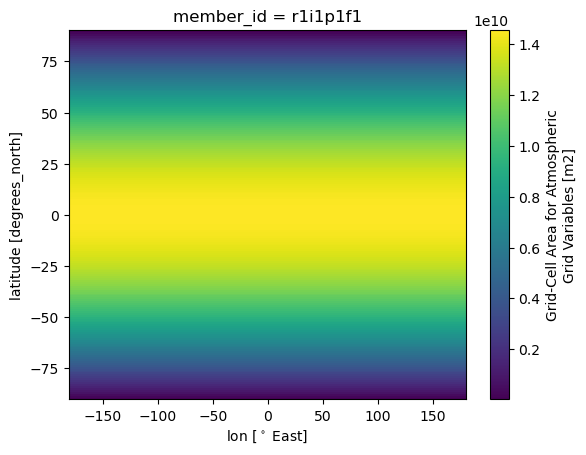

In [54]:
dss['areacella'].plot()

## 9. Convert to pandas & do some random fun stuff: 

Maybe we e.g. want to compare with a station, or just use some of the considerable functionalities available from pandas. It's easy to convert back and forth between xarray and pandas:

<span style="color:green;font-weight:700;font-size:20px">
A lot of these functions also exist in xarray!
</span>



## 10 Other stuff
### Pick out station: 

In [55]:
lat_kristineberg = 58.24
lon_kristineberg = 11.44
# pick out surface
ds_surf =dss.isel(lev=-1)
ds_kristineberg = ds_surf.sel(lat=lat_kristineberg, lon = lon_kristineberg, method ='nearest')

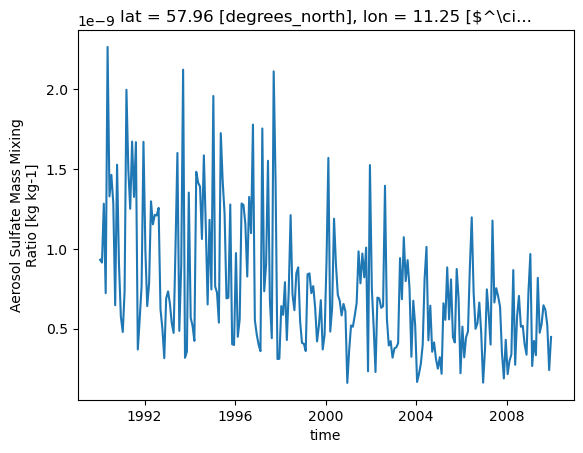

In [56]:
ds_kristineberg['mmrso4'].plot()

Pick out the vairables we need. 

In [57]:
vl = ['mmrso4','hurs','tas','T_C']

In [58]:
ds_kristineberg[vl]

<xarray.Dataset> Size: 6kB
Dimensions:    (member_id: 1, time: 240)
Coordinates:
    lat        float64 8B 57.96
    lon        float64 8B 11.25
  * member_id  (member_id) object 8B 'r1i1p1f1'
    lev        float64 8B -992.6
  * time       (time) datetime64[ns] 2kB 1990-01-15T12:00:00 ... 2009-12-15T1...
Data variables:
    mmrso4     (member_id, time) float32 960B dask.array<chunksize=(1, 1), meta=np.ndarray>
    hurs       (member_id, time) float32 960B dask.array<chunksize=(1, 1), meta=np.ndarray>
    tas        (member_id, time) float32 960B dask.array<chunksize=(1, 1), meta=np.ndarray>
    T_C        (member_id, time) float32 960B dask.array<chunksize=(1, 1), meta=np.ndarray>
Attributes: (12/57)
    Conventions:                      CF-1.7 CMIP-6.2
    activity_id:                      CMIP
    case_id:                          15
    cesm_casename:                    b.e21.BHIST.f09_g17.CMIP6-historical.001
    contact:                          cesm_cmip6@ucar.edu
    creation_date:                    2019-01-16T21:43:39Z
    ...                               ...
    intake_esm_attrs:activity_id:     CMIP
    intake_esm_attrs:institution_id:  NCAR
    intake_esm_attrs:version:         v20190308
    intake_esm_attrs:path:            /mnt/craas1-ns9989k-ns9560k/ESGF/CMIP6/...
    intake_esm_attrs:_data_format_:   netcdf
    intake_esm_dataset_key:           CMIP.historical.CESM2.fx.gn

### Resample:

In [59]:
ds_yearly = ds_kristineberg.resample(time='YE').mean('time')

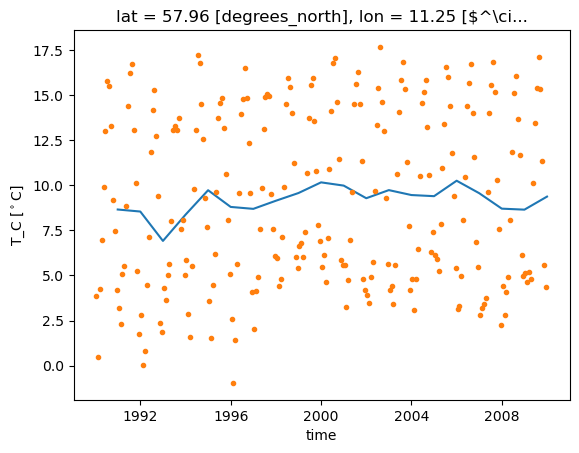

In [60]:
ds_yearly['T_C'].plot()
ds_kristineberg['T_C'].plot(linewidth=0, marker='.')

In [61]:
ds_kristineberg['season'] = ds_kristineberg['time.season']



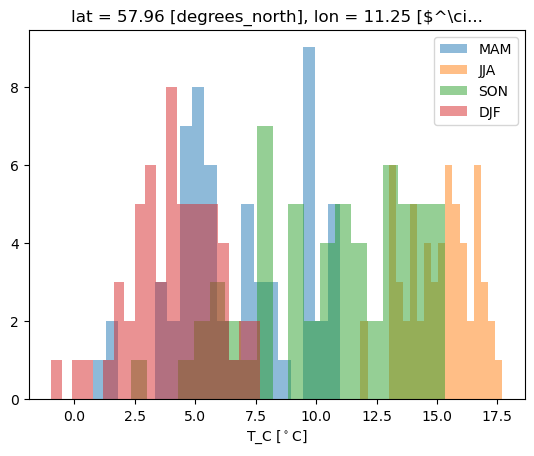

In [62]:
for s in ['MAM','JJA','SON','DJF']:
    ds_kristineberg.where(ds_kristineberg['season']==s)['T_C'].plot.hist(alpha=0.5, bins=20, label=s)
    
plt.legend()

### Obs: might want to convert to pandas
At this point we basically have a time series and the dataset is not to big, so might want to convert to pandas:

In [63]:
subset_of_variables = ['mmrso4','hurs','tas','T_C','season']
df_kristineberg = ds_kristineberg[subset_of_variables].squeeze().to_dataframe()
df_kristineberg

,mmrso4,hurs,tas,T_C,season,lat,lon,member_id,lev
time,,,,,,,,,
1990-01-15 12:00:00,9.319389e-10,85.651199,277.036011,3.886017,DJF,57.958115,11.25,r1i1p1f1,-992.556095
1990-02-14 00:00:00,9.139207e-10,79.779701,273.601807,0.451813,DJF,57.958115,11.25,r1i1p1f1,-992.556095
1990-03-15 12:00:00,1.282672e-09,82.473785,277.405701,4.255707,MAM,57.958115,11.25,r1i1p1f1,-992.556095
1990-04-15 00:00:00,7.225737e-10,79.588730,280.137329,6.987335,MAM,57.958115,11.25,r1i1p1f1,-992.556095
1990-05-15 12:00:00,2.263646e-09,80.421875,283.043152,9.893158,MAM,57.958115,11.25,r1i1p1f1,-992.556095
...,...,...,...,...,...,...,...,...,...
2009-08-15 12:00:00,6.469142e-10,82.338539,290.292358,17.142365,JJA,57.958115,11.25,r1i1p1f1,-992.556095
2009-09-15 00:00:00,6.174767e-10,75.105225,288.502136,15.352142,SON,57.958115,11.25,r1i1p1f1,-992.556095
2009-10-15 12:00:00,5.226203e-10,81.029533,284.518219,11.368225,SON,57.958115,11.25,r1i1p1f1,-992.556095


### lets do something unnecesarily complicated :D 

### Convert to pandas dataframe
Because more functionality

In [64]:
df = dss.isel(lev=-1)[vl].to_dataframe()

In [65]:
df_ri = df.reset_index()
df_ri.head()

,member_id,time,lat,lon,mmrso4,hurs,tas,T_C,lev
0,r1i1p1f1,1990-01-15 12:00:00,-90.0,-180.00,2.049096e-11,98.689842,242.897797,-30.252197,-992.556095
1,r1i1p1f1,1990-01-15 12:00:00,-90.0,-178.75,2.049095e-11,98.675537,242.903198,-30.246796,-992.556095
2,r1i1p1f1,1990-01-15 12:00:00,-90.0,-177.50,2.049095e-11,98.675537,242.903198,-30.246796,-992.556095
3,r1i1p1f1,1990-01-15 12:00:00,-90.0,-176.25,2.049095e-11,98.675537,242.903198,-30.246796,-992.556095
4,r1i1p1f1,1990-01-15 12:00:00,-90.0,-175.00,2.049095e-11,98.675537,242.903198,-30.246796,-992.556095


### qcut, cut

qcut splits the data into quantile ranges

In [66]:
df_ri['hurs_cat'] = pd.qcut(df_ri['hurs'],
                            q=[0.05,0.17, 0.34,0.66, 0.83,0.95],
                            labels=['very low','low','med','high','very high'])

Cut cuts into categories

In [67]:
df_ri['lat_cat'] = pd.cut(df_ri['lat'], [-90,-60,-30,0,30,60,90], 
                          labels=['S polar','S mid','S tropics', 'N tropic', 'N mid','N polar'])

In [68]:
df_ri

,member_id,time,lat,lon,mmrso4,hurs,tas,T_C,lev,hurs_cat,lat_cat
0,r1i1p1f1,1990-01-15 12:00:00,-90.0,-180.00,2.049096e-11,98.689842,242.897797,-30.252197,-992.556095,very high,NaN
1,r1i1p1f1,1990-01-15 12:00:00,-90.0,-178.75,2.049095e-11,98.675537,242.903198,-30.246796,-992.556095,very high,NaN
2,r1i1p1f1,1990-01-15 12:00:00,-90.0,-177.50,2.049095e-11,98.675537,242.903198,-30.246796,-992.556095,very high,NaN
3,r1i1p1f1,1990-01-15 12:00:00,-90.0,-176.25,2.049095e-11,98.675537,242.903198,-30.246796,-992.556095,very high,NaN
4,r1i1p1f1,1990-01-15 12:00:00,-90.0,-175.00,2.049095e-11,98.675537,242.903198,-30.246796,-992.556095,very high,NaN
...,...,...,...,...,...,...,...,...,...,...,...
13271035,r1i1p1f1,2009-12-15 12:00:00,90.0,173.75,5.152184e-11,106.941933,250.874847,-22.275146,-992.556095,NaN,N polar
13271036,r1i1p1f1,2009-12-15 12:00:00,90.0,175.00,5.151738e-11,106.943703,250.874573,-22.275421,-992.556095,NaN,N polar
13271037,r1i1p1f1,2009-12-15 12:00:00,90.0,176.25,5.151281e-11,106.945244,250.874329,-22.275665,-992.556095,NaN,N polar
13271038,r1i1p1f1,2009-12-15 12:00:00,90.0,177.50,5.150912e-11,106.946594,250.874100,-22.275894,-992.556095,NaN,N polar


In [69]:
df_ri.sample(n=20000).groupby('lat_cat').mean(numeric_only=True)

/tmp/ipykernel_14081/465231907.py:1: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  df_ri.sample(n=20000).groupby('lat_cat').mean(numeric_only=True)


,lat,lon,mmrso4,hurs,tas,T_C,lev
lat_cat,,,,,,,
S polar,-74.938019,-2.015824,2.571253e-11,95.192390,247.504166,-25.645840,-992.556095
S mid,-45.171888,-1.185364,1.620153e-10,79.848122,282.876770,9.726768,-992.556095
S tropics,-15.054866,0.087900,3.591108e-10,76.485733,297.266754,24.116770,-992.556095
N tropic,15.064793,-0.882442,1.276509e-09,72.494232,298.815186,25.665192,-992.556095
N mid,45.191990,-0.853557,1.281671e-09,72.892700,282.798279,9.648300,-992.556095
N polar,75.383530,0.788571,1.325593e-10,95.514252,263.269287,-9.880700,-992.556095


<Axes: xlabel='lat_cat', ylabel='hurs'>

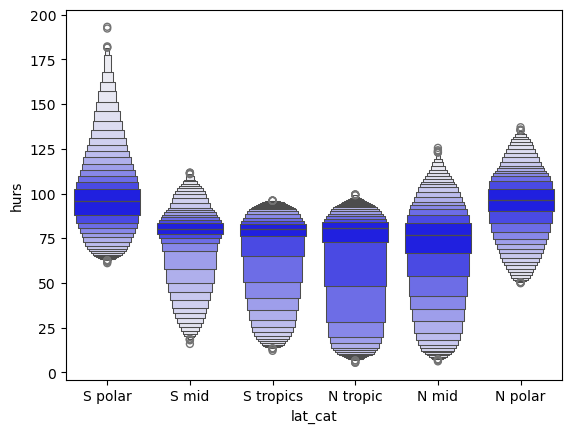

In [70]:
sns.boxenplot(x="lat_cat", y="hurs",
              color="b",
              #scale="linear", 
              width_method='linear',
              data=df_ri)#.sample(n=20000))

<Axes: xlabel='hurs_cat', ylabel='mmrso4'>

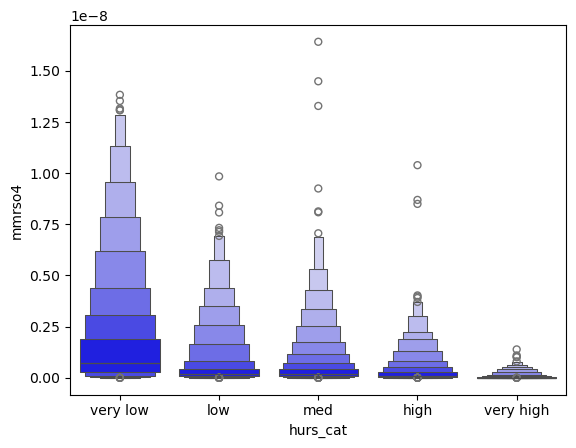

In [71]:
sns.boxenplot(x="hurs_cat", 
              y="mmrso4",
              color="b",
              width_method='linear',
              data=df_ri.sample(n=20000),
             )

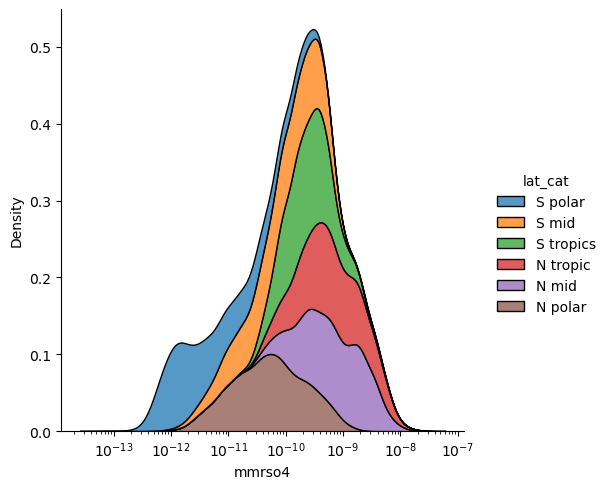

In [72]:
sns.displot(x="mmrso4",
            hue='lat_cat',
            log_scale=True,
            kind='kde',
            data=df_ri.sample(n=20000), 
            multiple="stack"
           )

### Convert back to xarray if we need:

In [73]:
ds_new = df_ri.set_index(['time','lat','lon']).to_xarray()

In [74]:
ds_new

<xarray.Dataset> Size: 637MB
Dimensions:    (time: 240, lat: 192, lon: 288)
Coordinates:
  * time       (time) datetime64[ns] 2kB 1990-01-15T12:00:00 ... 2009-12-15T1...
  * lat        (lat) float64 2kB -90.0 -89.06 -88.12 -87.17 ... 88.12 89.06 90.0
  * lon        (lon) float64 2kB -180.0 -178.8 -177.5 ... 176.2 177.5 178.8
Data variables:
    member_id  (time, lat, lon) object 106MB 'r1i1p1f1' ... 'r1i1p1f1'
    mmrso4     (time, lat, lon) float32 53MB 2.049e-11 2.049e-11 ... 5.151e-11
    hurs       (time, lat, lon) float32 53MB 98.69 98.68 98.68 ... 106.9 106.9
    tas        (time, lat, lon) float32 53MB 242.9 242.9 242.9 ... 250.9 250.9
    T_C        (time, lat, lon) float32 53MB -30.25 -30.25 ... -22.28 -22.28
    lev        (time, lat, lon) float64 106MB -992.6 -992.6 ... -992.6 -992.6
    hurs_cat   (time, lat, lon) object 106MB 'very high' 'very high' ... nan nan
    lat_cat    (time, lat, lon) object 106MB nan nan nan ... 'N polar' 'N polar'

### mask by category 

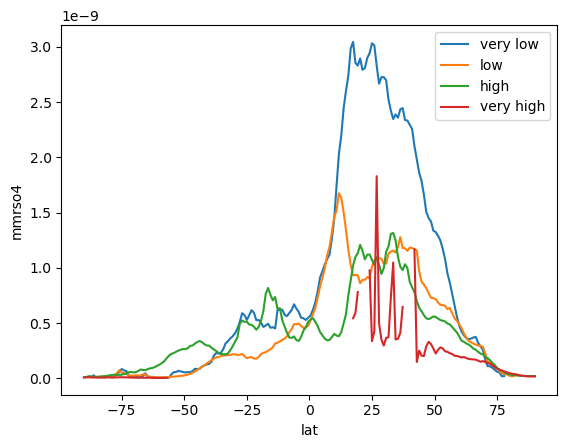

In [75]:
ds_new.where(ds_new['hurs_cat']=='very low').mean(['time','lon'])['mmrso4'].plot(label='very low')#vmin = 0, vmax = 1.5e-8)
ds_new.where(ds_new['hurs_cat']=='low').mean(['time','lon'])['mmrso4'].plot(label='low')#vmin = 0, vmax = 1.5e-8)

ds_new.where(ds_new['hurs_cat']=='high').mean(['time','lon'])['mmrso4'].plot(label='high')#vmin = 0, vmax = 1.5e-8)
ds_new.where(ds_new['hurs_cat']=='very high').mean(['time','lon'], keep_attrs=True)['mmrso4'].plot(label='very high')#vmin = 0, vmax = 1.5e-8)
plt.legend()

### Improve and reduce risk of typo:

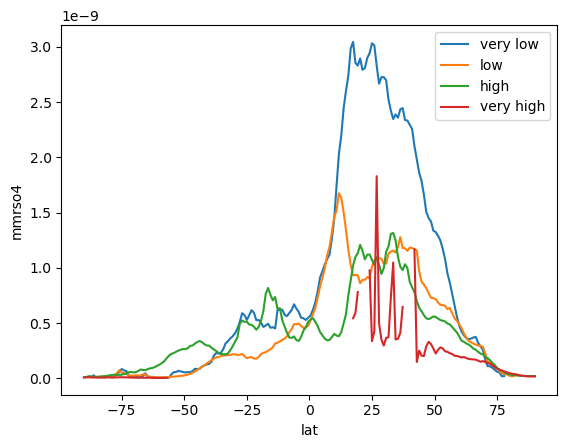

In [76]:
for cat in ['very low','low','high','very high']:
    ds_new.where(ds_new['hurs_cat']==cat).mean(['time','lon'])['mmrso4'].plot(label=cat) 
plt.legend()